#Final Project For CSCI 4050

Start with imports

In [ ]:
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

Importing CSV data for tesla stock prices from past 5 years

In [ ]:
url = 'https://raw.githubusercontent.com/Jefferson-Xie/ML/main/TSLA.csv'
df = pd.read_csv(url)

In [ ]:
# View head and tail of dataframe
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-12,192.800003,194.419998,191.039993,192.429993,192.429993,2438876
1,2016-12-13,193.179993,201.279999,193.000000,198.149994,198.149994,6823884
2,2016-12-14,198.740005,203.000000,196.759995,198.690002,198.690002,4150927
3,2016-12-15,198.410004,200.740005,197.389999,197.580002,197.580002,3219567
4,2016-12-16,198.080002,202.589996,197.600006,202.490005,202.490005,3796889


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2021-12-06,1001.510010,1021.640015,950.500000,1009.010010,1009.010010,27221037
1255,2021-12-07,1044.199951,1057.673950,1026.810059,1051.750000,1051.750000,18694857
1256,2021-12-08,1052.709961,1072.380005,1033.000122,1068.959961,1068.959961,13968790
1257,2021-12-09,1060.640015,1062.489990,1002.359985,1003.799988,1003.799988,19446486
1258,2021-12-10,1008.750000,1020.979675,982.530029,1017.030029,1017.030029,19229185


In [ ]:
# For simplicity, I will be using only the closing price; but for a more "accurate" model, a combination of open, high, low, and close can be used then combined
df_close = df.reset_index()['Close']

In [ ]:
print(np.array(df_close)[:, np.newaxis])

[[ 192.429993]
 [ 198.149994]
 [ 198.690002]
 ...
 [1068.959961]
 [1003.799988]
 [1017.030029]]


In [ ]:
df_close.shape

(1259,)

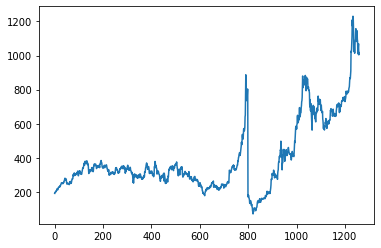

In [ ]:
# Initial View
pl.plot(df_close)

#Preprocessing
As discussed in lab4, data needs to be normalized between ranges for [-1,1] for machine learning to work well.

In [ ]:
# Split the data into training and test data
train_size = int(len(df_close)*0.8)
test_size = len(df_close)-train_size
train_split,test_split = df_close[0:train_size], df_close[train_size:len(df_close)]

# Apply Normalization to both
#scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
train_data, test_data = scaler.fit_transform(np.array(train_split).reshape(-1,1)), scaler.fit_transform(np.array(test_split).reshape(-1,1))

In [ ]:
train_data.shape, test_data.shape

((1007, 1), (252, 1))

Next we need to convert array into useable dataset. Method to create dataset matrix taken from: https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# Use function to convert data into matrix
step = 100
x_train , y_train = create_dataset(train_data, step)
x_test, y_test = create_dataset(test_data, step)

print(x_train.shape), print(y_train.shape)
print(x_test.shape), print(y_test.shape)

(906, 100)
(906,)
(151, 100)
(151,)


(None, None)

In [ ]:
# Next data needs to be reshaped to fit LSTM. 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

#Create Model


In [ ]:
model = models.Sequential([
    layers.Input(shape=(100,1)),
    layers.LSTM(50, return_sequences=True),
    layers.LSTM(50, return_sequences=True, recurrent_dropout=0.2),
    layers.LSTM(50),
    layers.Dropout(0.2),
    layers.Dense(50),
    layers.Dense(1),
])

In [ ]:
model.compile(
    loss = losses.MeanSquaredError(),
    optimizer = optimizers.Adam(),
    metrics = ['mean_squared_error'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 53,401
Trainable params: 53,401
Non-traina

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=200, verbose=2)

Epoch 1/200
15/15 - 13s - loss: 0.6533 - mean_squared_error: 0.6533 - 13s/epoch - 842ms/step
Epoch 2/200
15/15 - 3s - loss: 0.3380 - mean_squared_error: 0.3380 - 3s/epoch - 219ms/step
Epoch 3/200
15/15 - 3s - loss: 0.2634 - mean_squared_error: 0.2634 - 3s/epoch - 219ms/step
Epoch 4/200
15/15 - 3s - loss: 0.1940 - mean_squared_error: 0.1940 - 3s/epoch - 218ms/step
Epoch 5/200
15/15 - 3s - loss: 0.1724 - mean_squared_error: 0.1724 - 3s/epoch - 216ms/step
Epoch 6/200
15/15 - 3s - loss: 0.1559 - mean_squared_error: 0.1559 - 3s/epoch - 217ms/step
Epoch 7/200
15/15 - 3s - loss: 0.1564 - mean_squared_error: 0.1564 - 3s/epoch - 219ms/step
Epoch 8/200
15/15 - 3s - loss: 0.1454 - mean_squared_error: 0.1454 - 3s/epoch - 219ms/step
Epoch 9/200
15/15 - 3s - loss: 0.1736 - mean_squared_error: 0.1736 - 3s/epoch - 218ms/step
Epoch 10/200
15/15 - 3s - loss: 0.1211 - mean_squared_error: 0.1211 - 3s/epoch - 218ms/step
Epoch 11/200
15/15 - 3s - loss: 0.1105 - mean_squared_error: 0.1105 - 3s/epoch - 219ms/

#Performance
Next we evaluate model performance

In [ ]:
# First we make the predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Next we use inverse_transform to undo the scaling performed earlier
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [ ]:
import math
_, mse_train = model.evaluate(x_train, y_train)
print("MSE: %.2f RMSE: %.2f" % (mse_train, math.sqrt(mse_train)))

29/29 [==============================] - 2s 38ms/step - loss: 0.1061 - mean_squared_error: 0.1061
MSE: 0.11 RMSE: 0.33


In [ ]:
_, mse_test = model.evaluate(x_test, y_test)
print("MSE: %.2f RMSE: %.2f" % (mse_test, math.sqrt(mse_test)))

5/5 [==============================] - 0s 43ms/step - loss: 0.1369 - mean_squared_error: 0.1369
MSE: 0.14 RMSE: 0.37


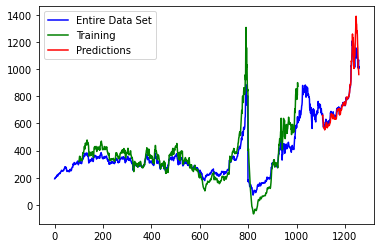

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(np.array(df_close)[:, np.newaxis])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step:len(train_predict)+step, :] = train_predict-440
# shift test predictions for plotting
testPredictPlot = np.empty_like(np.array(df_close)[:, np.newaxis])
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(step*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions


pl.plot(df_close, "-b", label="Entire Data Set")
pl.plot(trainPredictPlot, "-g", label="Training")
pl.plot(testPredictPlot, "-r", label="Predictions")
pl.legend(loc="upper left")
pl.show()